In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial import ConvexHull

from shapely.geometry import Polygon, MultiPolygon

# few less-common pip packages
import alphashape
import tripy


#Import a few utility functions...
import sys
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../cython")
#sys.path.insert(0, "../")

#Try pulling from the local CGAL folders
from CGAL import CGAL_Alpha_shape_2 as CGAL_alphashape
import cgal_partition
#So we can import my local libs
import CommChannel as CC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr


def indices_to_pts(r, region, res):
    #First get the non-zero indices
    idcs = np.where(r>0)
    pts = np.array(idcs).T - [region[1], region[3]]
    pts = pts/res
    return pts, np.array(idcs).T

In [2]:
#Setup the system:

#For now, use same channel params
nPL = 4.2  
kPL = -40

decorrSH = 3.09    
alpha = 8.41
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1



#6 remote stations
qBase = np.array([[25,26], [2,2], [26,24], [48,2], [24, 24], [24,49]])
cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
#Create Comm Channels
ccs = [CC.CommChannel(cps[i], region, res) for i in range(len(cps))]
for cc in ccs:
        cc.generateSH();#cc.generateMP(2)

Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.
Generating shadowing...
Shadowing generation complete.


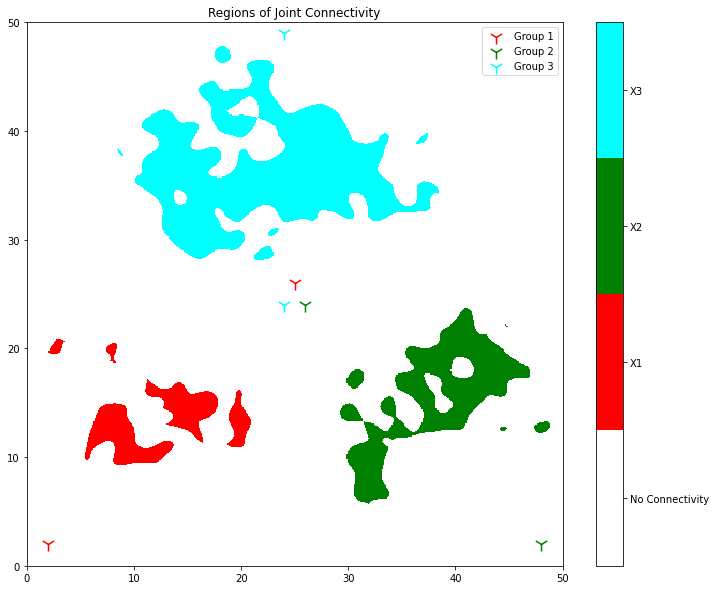

In [3]:
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()    
plt.show()

In [4]:
pts1, idcs1 = indices_to_pts(r1, region, res)
pts2, idcs2 = indices_to_pts(r2, region, res)
pts3, idcs3 = indices_to_pts(r3, region, res)

all_pts, _ = indices_to_pts(np.ones(r1.shape), region, res)

els = [0.5, 0.7, 0.5]
beta = 0.2
dt_sys = dtr.DTR(ccs, els, beta)

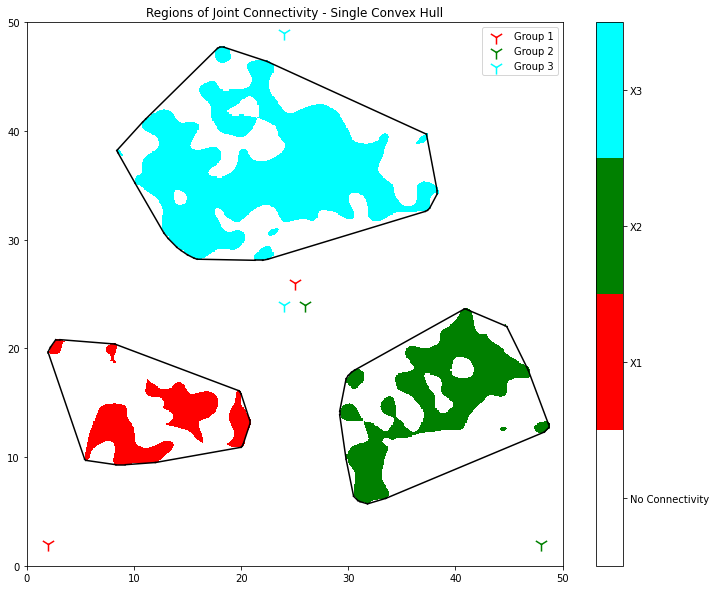

In [5]:
#SINGLE CONVEX HULL
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - Single Convex Hull', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for i in range(3):
    points = dt_sys.Xis[i]['points']
    hull = ConvexHull(points)
    #plt.plot(points[:,0], points[:,1], 'o')

    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

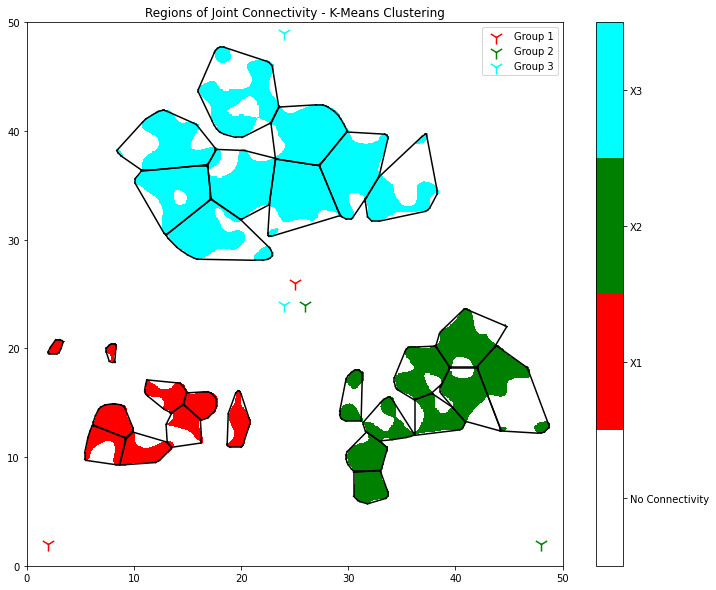

In [6]:
#Kmeans with large k
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - K-Means Clustering', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for i in range(3):
    points = dt_sys.Xis[i]['points']

    k=9
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=1).fit(points)
    kml = kmeans.labels_
    idcs = [np.where(kml == c) for c in range(k)]

    for i in range(k):
        pts = points[idcs[i]]
        hull = ConvexHull(pts)
        #plt.plot(pts[:,0], pts[:,1], 'o')

        for simplex in hull.simplices:
            plt.plot(pts[simplex, 0], pts[simplex, 1], 'k-', )
            
plt.show()

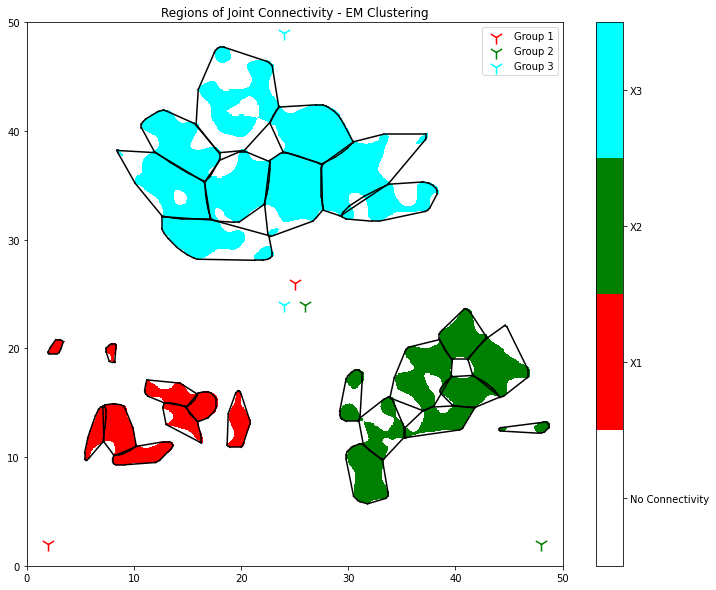

In [7]:
#EM
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - EM Clustering', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for j in range(3):
    points = dt_sys.Xis[j]['points']

    min_bic = np.Inf
    n_comp = -1
    best_labels = None
    for k in range(2,10):
        gmm = GaussianMixture(n_components = k, n_init=10)
        labels = gmm.fit_predict(points)
        bic = gmm.bic(points)
        if bic < min_bic:
            min_bic = bic
            n_comp = k
            best_labels = labels


    idcs = [np.where(best_labels == c) for c in range(n_comp)]


    for i in range(n_comp):
        pts = points[idcs[i]]
        hull = ConvexHull(pts)
        #plt.plot(pts[:,0], pts[:,1], 'o')

        for simplex in hull.simplices:
            plt.plot(pts[simplex, 0], pts[simplex, 1], 'k-')

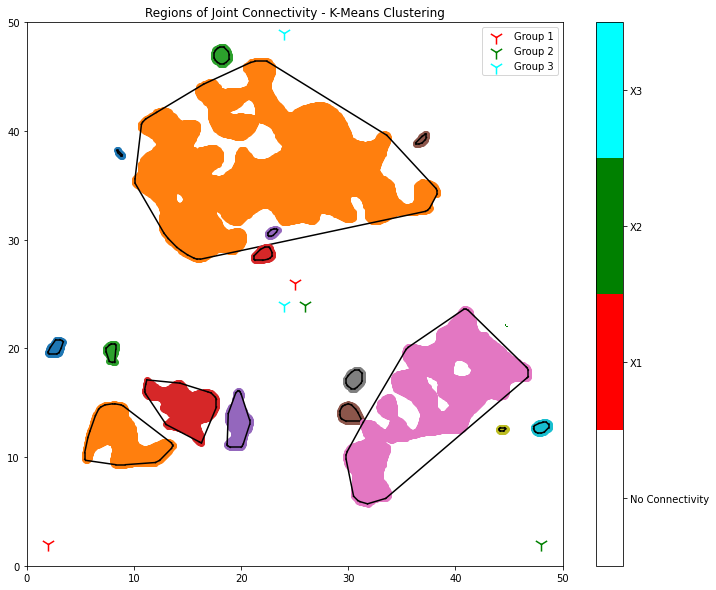

In [8]:
#with DBSCAN
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - K-Means Clustering', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for i in range(3):
    points = dt_sys.Xis[i]['points']
    clustering = DBSCAN(eps=(1.5)/res, min_samples=5).fit(points)
    labels = clustering.labels_
    c_count = len(set(labels))
    idcs = [np.where(labels == c) for c in range(c_count)]


    for i in range(c_count):
        if len(idcs[i][0]) == 0:
            continue
        pts = points[idcs[i]]
        hull = ConvexHull(pts)
        plt.plot(pts[:,0], pts[:,1], 'o')

        for simplex in hull.simplices:
            plt.plot(pts[simplex, 0], pts[simplex, 1], 'k-')
            
plt.show()

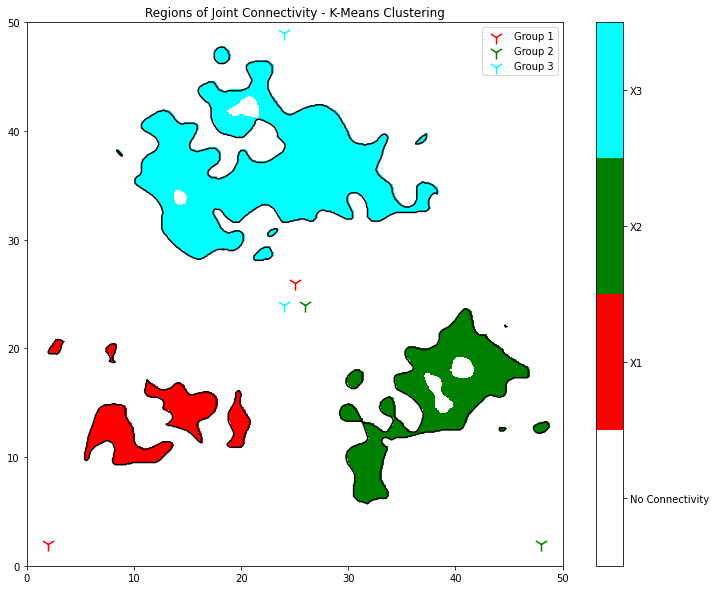

In [9]:
#With Alphashape
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - K-Means Clustering', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for i in range(3):
    points = dt_sys.Xis[i]['points']
    shapes = alphashape.alphashape(points, 4)
    #plot the shape(s)
    if isinstance(shapes, MultiPolygon):
        for shape in shapes:
            #get vertices
            x,y = shape.exterior.coords.xy
            plt.plot(x,y, 'k-')
            #this triangulation tends to be not very great
#             vertices = [(x[i], y[i]) for i in range(len(x))]
#             triangulation = tripy.earclip(vertices)
#             for triangle in triangulation:
#                 t_np = np.array(triangle)
#                 plt.plot(t_np[:,0], t_np[:,1])
    elif isinstance(shapes, Polygon):
        x,y = shapes.exterior.coords.xy
        plt.plot(x,y, 'k-')
    else:
        print('Non-polygonal shape found: %s'%type(shapes))
    
plt.show()

In [10]:
from CGAL.CGAL_Kernel import Point_2

def to_CGAL_Points(np_pts):
    CGAL_pts = []
    for pt in np_pts:
        CGAL_pt = Point_2(pt[0], pt[1])
        CGAL_pts.append(CGAL_pt)
        
    return CGAL_pts

Number of shapes 5
	4 Subregions
	5 Subregions
	12 Subregions
	26 Subregions
	28 Subregions
Number of shapes 5
	1 Subregions
	2 Subregions
	3 Subregions
	4 Subregions
	4 Subregions
	9 Subregions
	88 Subregions
Number of shapes 6
	3 Subregions
	3 Subregions
	4 Subregions
	6 Subregions
	4 Subregions
	5 Subregions
	2 Subregions
	42 Subregions


<Figure size 1440x1440 with 0 Axes>

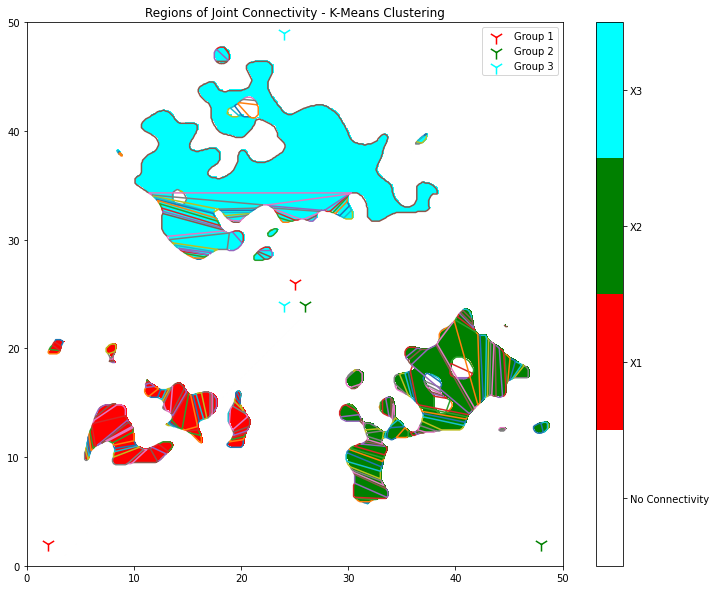

In [179]:
#With
fig = plt.figure(figsize=(20,20))
color_array=['white', 'red', 'green', 'cyan']
#plot the connectivity fields
cfs = [cc.getConnectionField(-92) for cc in ccs]
r1 = 1*cfs[0]*cfs[1]; r2 = 2*cfs[2]*cfs[3]; r3 = 3*cfs[4]*cfs[5];
cmap = ListedColormap(color_array)
ticks =[0.75/2,1.5-0.75/2, 1.5+0.75/2, 3-0.75/2]
tick_labels = ['No Connectivity','X1', 'X2', 'X3']
CC.plotField(region, r1+r2+r3, 'Regions of Joint Connectivity - K-Means Clustering', cmap=cmap,
             ticks=ticks, tick_labels = tick_labels, do_show=False)

for i in range(3):
    plt.scatter([qBase[2*i][0], qBase[2*i+1][0]], [qBase[2*i][1], qBase[2*i+1][1]],
                label='Group %d'%(i+1), color=color_array[i+1], marker='1', s=200)
plt.legend()

for i in range(3):
    points = dt_sys.Xis[i]['points']
    CGAL_pts = to_CGAL_Points(points)
    shapes = CGAL_alphashape.Alpha_shape_2(CGAL_alphashape.REGULARIZED)
    shapes.make_alpha_shape(CGAL_pts)
    shapes.set_alpha(0.1)
    polys = extract_polys(shapes)
    
    print("Number of shapes %d"%(shapes.number_of_solid_components()))
    for poly in polys:
        poly.make_cc()
        #now decompose this bad boi
        pts = poly.as_np_array()
        cnvx_polys = cgal_partition.optmal_convex_parition(pts)
        #cnvx_polys = cgal_partition.hertel_mehlhorn(pts)
        print("\t%d Subregions"%(len(cnvx_polys)))
        for cnvx in cnvx_polys:
            plt.plot(cnvx[:,0], cnvx[:,1])
        
    
plt.show()

In [178]:
class PolyConstructor:
    
    def __init__(self, edge):
        self.points = [edge.point(0), edge.point(1)]
        self.complete = False
        self.merged = False
        
    def _signed_area(self):
        area = None
        if self.complete:
            n = len(self.points)
            area = 0
            for i in range(n):
                pi = self.points[i]
                pj = self.points[(i+1)%n]
                area += (pj.x() - pi.x())*(pj.y() + pi.y())
        return area
    
    def is_cc(self):
        if not self.complete:
            return None
        return self._signed_area() < 0
    
    def make_cc(self):
        if not self.is_cc():
            self.flip()
    
    def try_merge(self, other):
        if self.complete:
            return False
        
        did_merge = self._try_merge(other)
                
        if not did_merge:
            did_merge = self._try_merge(other.flip())
        
        if did_merge:
            other.merged = True
        
        return did_merge
    
    def as_np_array(self):
        return np.array([[point.x(), point.y()] for point in self.points])
    
    def _try_merge(self, other):
        did_merge = False
        if self.points[0] == other.points[-1]:
            #prepend
            self.points = other.points[:-1] + self.points
            did_merge = True
            
        if self.points[-1] == other.points[0]:
            if did_merge:
                self.complete = True
                #and just trim off the last one, which is redundant, since we just added the new points
                self.points = self.points[:-1]
            else:
                self.points = self.points[:-1] + other.points
                did_merge = True
                
        return did_merge
    
    def flip(self):
        self.points.reverse()
        return self
    
    def plot(self):
        plot_points = self.as_np_array()
        p0 = self.points[0]
        np.concatenate((plot_points, [[p0.x(), p0.y()]]),axis=0)
        plt.plot(plot_points[:,0], plot_points[:,1])
    
    def __str__(self):
        pstr = 'PolyConstructor:'
        for point in self.points:
            pstr += ' ('+str(point) + ') '
        return pstr
    

def extract_polys(cgala):
    incompletes = [PolyConstructor(shapes.segment(it)) for it in cgala.alpha_shape_edges()]
    completes = []
    while len(incompletes)>0:
        #print(len(incompletes))
        temp_incompletes = []
        
        for i in range(len(incompletes)):
            #print(incompletes[i])
            if not incompletes[i].merged:#if it was merged, just ignore
                for j in range(i+1,len(incompletes)):
                    #try to merge
                    if not incompletes[j].merged:
                        incompletes[i].try_merge(incompletes[j])
                    
                if incompletes[i].complete:
                    completes.append(incompletes[i])
                else:
                    temp_incompletes.append(incompletes[i])
                
        incompletes = temp_incompletes
                
    return completes   

def poly_area(points):
    area = 0
    n = len(points)
    for i in range(n):
        pi = points[i]
        pj = points[(i+1)%n]
        area += pi[0]*pj[1] - pi[1]*pj[0]
        
    return area

In [96]:
#extract_polys(shapes)

In [157]:
class WEdge:
    
    def __init__(self, p0, p1):
        self.p0 = p0
        self.p1 = p1
        
    def point(self, idx):
        if idx == 0:
            return self.p0
        elif idx == 1:
            return self.p1
        else:
            return None

incompletes = [PolyConstructor(shapes.segment(it)) for it in shapes.alpha_shape_edges()]
completes = []
while len(incompletes)>0:
    print(len(incompletes))
    temp_incompletes = []

    for i in range(len(incompletes)):
        #print(incompletes[i])
        if not incompletes[i].merged:#if it was merged, just ignore
            for j in range(i+1,len(incompletes)):
                #try to merge
                if not incompletes[j].merged:
                    incompletes[i].try_merge(incompletes[j])
                    #print("Updated to: ", incompletes[i])

            if incompletes[i].complete:
                completes.append(incompletes[i])
            else:
                temp_incompletes.append(incompletes[i])

    incompletes = temp_incompletes

completes


1072
355
114
32
12
5
2


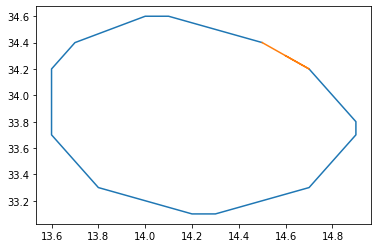

In [172]:

poly1 = completes[0]
poly1.make_cc()
#ok now we have to try to figure out this very bad boi
# shapes = cgal_partition.hertel_mehlhorn(poly1.as_np_array())
shapes = cgal_partition.optmal_convex_parition(poly1.as_np_array())
for shape in shapes:
    plt.plot(shape[:,0], shape[:,1])

In [163]:
poly1.plot()


NameError: name 'plot_poinnts' is not defined

In [143]:
shapes

[array([[14.69999981, 34.20000076],
        [14.80000019, 34.        ],
        [14.89999962, 33.79999924],
        [14.89999962, 33.70000076],
        [14.80000019, 33.5       ],
        [14.69999981, 33.29999924],
        [14.5       , 33.20000076],
        [14.30000019, 33.09999847],
        [14.19999981, 33.09999847],
        [14.        , 33.20000076],
        [13.80000019, 33.29999924],
        [13.69999981, 33.5       ],
        [13.60000038, 33.70000076],
        [13.60000038, 33.79999924],
        [13.60000038, 33.90000153],
        [13.60000038, 34.        ],
        [13.60000038, 34.09999847],
        [13.60000038, 34.20000076],
        [13.69999981, 34.40000153],
        [14.        , 34.59999847],
        [14.10000038, 34.59999847],
        [14.30000019, 34.5       ],
        [14.5       , 34.40000153]]),
 array([[14.60000038, 34.29999924],
        [14.69999981, 34.20000076],
        [14.5       , 34.40000153]])]

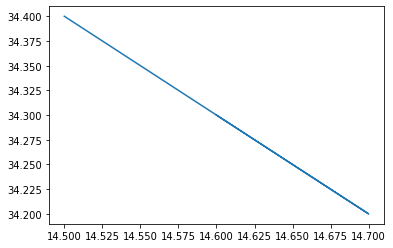

In [164]:
plt.plot(shapes[1][:,0], shapes[1][:,1])

In [167]:


poly_area(shapes[1])

2.861015673261136e-07